In [1]:
%%capture
!pip install ir_datasets
!pip install unidecode

import numpy as np
import ir_datasets
import string
import re
import unidecode
import pandas as pd
from numpy.linalg import norm
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter

import nltk            
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.metrics import ndcg_score

## Imply Indexing method 

The dataset we used is the online dataset "scifact_train", imported from the ir_dataset.  
We copied and pasted small portion of data sample to the file 
"dataset_template.xlsx".

In [2]:
# dataset from the web, no local data required
# use the python API to download scifact dataset
dataset = ir_datasets.load("beir/scifact/train")

# print the database size and format
print('\n', dataset.docs_count(), 'documents with format:\n\t', 
      dataset.docs_cls().__annotations__)
print('\n', dataset.queries_count(), 'queries with format:\n\t', 
      dataset.queries_cls().__annotations__)
print('\n', dataset.qrels_count(), 'query relevance judgements with format:\n\t', 
      dataset.qrels_cls().__annotations__)


 5183 documents with format:
	 {'doc_id': <class 'str'>, 'text': <class 'str'>, 'title': <class 'str'>}

 809 queries with format:
	 {'query_id': <class 'str'>, 'text': <class 'str'>}

 919 query relevance judgements with format:
	 {'query_id': <class 'str'>, 'doc_id': <class 'str'>, 'relevance': <class 'int'>, 'iteration': <class 'str'>}


In [3]:
# extract the document, query and query relevance usring python API
for document in dataset.docs_iter()[:1]: 
  None
for query in dataset.queries_iter(): 
  None
for relevance in dataset.qrels_iter(): 
  None

In [4]:
# extract the doucment text list, document id list, query list, query relevance judgement list
temp_doc = []
document_id_list = []
query_list = []
relve_list = []

# load all document data to the document list
document = []
for document in dataset.docs_iter():
    #temp_doc.append([document[0],document[1],document[2],document[3]])
    temp_doc.append([document[0],document[1],document[2]])
document_list = [document[1] for document in temp_doc]       # select the document text part
#print("The document template:" + str(temp_doc[9])) 

# load all document id to the document id list
for document in temp_doc:
    document_id_list.append([document[0],document[1]])        # No need of document title

print("\nThe list has " + str(len(document_list)) + " documents") 
print("\nExample, the first doucment text is: \n" + document_list[0][:100] + " ...") 

# load all queries content to the query list
for query in dataset.queries_iter():
  query_list.append(query[1])
print("\nThe list has " + str(len(query_list)) + " queries") 
print("\nExample,the first query is: \n" + str(query_list[:1])) 

# load all query relevances to the query list
for qrel in dataset.qrels_iter():        # query relevance judgements, used for evaluation
  relve_list.append(qrel)
print("\nThe list has " + str(len(query_list)) + " query relevances")
print("\nExample,the first query relevance is: \n" + str(relve_list[:1]))


The list has 5183 documents

Example, the first doucment text is: 
Alterations of the architecture of cerebral white matter in the developing human brain can affect co ...

The list has 809 queries

Example,the first query is: 
['0-dimensional biomaterials lack inductive properties.']

The list has 809 query relevances

Example,the first query relevance is: 
[TrecQrel(query_id='0', doc_id='31715818', relevance=1, iteration='0')]


In [5]:
def document_cleaner(text):
  number_cleaned_text = re.sub(r'\d+', '', text) 
  puntuation_cleaned_text = re.sub(r"[^\w\s]|_", "", number_cleaned_text)
  cleaned_text = re.sub('\s+', ' ', puntuation_cleaned_text).strip()     #clean the whitespaces in context

  return cleaned_text

# preprocessing
def pre_processing(doc_list):

  stop_words = set(stopwords.words('english'))
  snow_stemmer = SnowballStemmer(language='english')

  #stage1: context removing
  stage1_list = []
  for doc in doc_list:
    problem_removed_doc = document_cleaner(doc)
    stage1_list.append(problem_removed_doc)
  
  #stage2: tokenization
  stage2_list = []
  for doc in stage1_list:
    tokenized_doc = word_tokenize(doc)
    stage2_list.append(tokenized_doc)

  #stage3: stopwords removing
  stage3_list = []
  for doc in stage2_list:
    stopwords_removed_list = [stop_w for stop_w in doc if not stop_w.lower() in stop_words]
    stopwords_removed_list = []
    for word in doc:
      if word not in stop_words:
        stopwords_removed_list.append(word)
    stage3_list.append(stopwords_removed_list)
  
  #stage4: lemmatization
  stage4_list = []
  P_lemmatizer = WordNetLemmatizer()
  for doc in stage3_list:
    lemmatization_list = []
    for word in doc:
      x = P_lemmatizer.lemmatize(word)
      lemmatization_list.append(x)
    stage4_list.append(lemmatization_list)
  
  #stage5: snowball stemming
  stage5_list = []
  for doc in stage4_list:
      stems = []
      for word in doc:
          stemmed_word = snow_stemmer.stem(word)
          stems.append(stemmed_word)
      stage5_list.append(stems)
    
  #stage6: Return result
  pre_processed_doc = []
  for doc in stage5_list:
      pre_processed_doc.append(' '.join(doc))    #use the blank to sepearate the documents
  return pre_processed_doc

In [6]:
# execute preprocessing to all documents and queries
pre_processed_document = pre_processing(document_list)
pre_processed_query = pre_processing(query_list)

print('\nDocument before preprocessing: "' + document_list[0][:80] + "... ")
print('\nDocument after preprocessing: "' + pre_processed_document[0][:80] + "... ")
print('\nQuery before preprocessing: "' + query_list[0] + "... ")
print('\nQuery after preprocessing: "' + pre_processed_query[0] + "... ")


Document before preprocessing: "Alterations of the architecture of cerebral white matter in the developing human... 

Document after preprocessing: "alter architectur cerebr white matter develop human brain affect cortic develop ... 

Query before preprocessing: "0-dimensional biomaterials lack inductive properties.... 

Query after preprocessing: "dimension biomateri lack induct properti... 


In [7]:
# vectorizing the document with term frequency
vectorizer = CountVectorizer()                           # follow lab2, choose CountVectorizer in skLearn as the TF vectorizer
vectorized_document = vectorizer.fit_transform(pre_processed_document).toarray()
vocabulary = vectorizer.get_feature_names_out()

scifact_TF_matrix = pd.DataFrame(vectorized_document, columns = vocabulary)   # the term frequency matrix for "scifact" dataset data
scifact_TF_matrix

,aa,aaa,aaaatpas,aaafamili,aab,aabenhus,aacr,aacrthi,aad,aadinduc,...,μm,μmolkg,μmoll,μmwide,μs,σe,σg,χ²,ωloop,ﬁnding
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Term frequency matrix indexing:

In [8]:
# retrieve query id 
query_id_list = []
for query in dataset.queries_iter():       # using the python API
  query_id_list.append(query[0])
query_id_list = [eval(i) for i in query_id_list]      # using the eval() to convert 
query_dictionary = dict(zip(query_id_list, query_list))    # bind the query and and query document in a dictionary
queries = [list(query_pair) for query_pair in zip(query_id_list,pre_processed_query)]        # query pairs

print("\nNumber of query pairs: " + str(len(queries)))
print("\nExample query pair: " + str(queries[0]))
print("\nTop 100 query id: " + str(query_id_list[:100]))          # get the top100 query ids that need to evaluate later


Number of query pairs: 809

Example query pair: [0, 'dimension biomateri lack induct properti']

Top 100 query id: [0, 2, 4, 6, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 32, 34, 35, 37, 39, 40, 41, 43, 44, 45, 46, 47, 52, 55, 58, 60, 61, 62, 63, 64, 66, 67, 68, 69, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 85, 86, 88, 89, 90, 91, 92, 93, 95, 96, 98, 104, 105, 106, 108, 109, 111, 112, 114, 116, 119, 120, 121, 122, 123, 126, 134, 138, 139, 144, 149, 152, 153, 154, 155, 156, 157, 159, 160, 161, 164, 165, 166, 167]


In [9]:
# TF index term weighting 
def TF_query_vectorizer(query_document):
    vectorizer = CountVectorizer(stop_words='english')                   # choose countvectorizer in skLearn
    documents_vectorized = vectorizer.fit_transform([query_document])           # use the skLearn fit_transform function to CV normalize the query set.
    query_vocabulary_list = vectorizer.get_feature_names_out()               # get the query document vocabulary list
    TF_vector_array = np.array([])                      # use numpy create a blank 2D array
    for term in scifact_TF_matrix.columns:              # put all document vocab terms and give all terms binary weights
      if term in query_vocabulary_list: 
        TF_vector_array = np.append(TF_vector_array,1)          # if term element present in vocabulary list, give weight 1
      else: 
        TF_vector_array = np.append(TF_vector_array,0)          # if not, give weight 0
    return TF_vector_array, query_vocabulary_list

In [10]:
# vectorizing example
# the top 100 queries id list, evaluate precise
# test_query_id_list = [0, 2, 4, 6, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 32, 34, 35, 37, 39, 40, 41, 43, 44, 45, 46, 47, 52, 
# 55, 58, 60, 61, 62, 63, 64, 66, 67, 68, 69, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 85, 86, 88, 89, 90, 91, 92, 93, 95, 96, 98, 104, 105, 106, 
# 108, 109, 111, 112, 114, 116, 119, 120, 121, 122, 123, 126, 134, 138, 139, 144, 149, 152, 153, 154, 155, 156, 157, 159, 160, 161, 164, 165, 166, 167]

test_id_number = 30                               # set the test query id number that want to test
result_query = [query_pair for query_pair in queries if query_pair[0] == test_id_number][0][1]    # match the confirmed query pair
TF_vector_array, query_vocabulary_list = TF_query_vectorizer(result_query)     #TF vector for VSM, Vocabulary list for BM25         
print("TF vector:", TF_vector_array)
print("Query vocabulary:", query_vocabulary_list)

TF vector: [0. 0. 0. ... 0. 0. 0.]
Query vocabulary: ['breast' 'cancer' 'capac' 'influenc' 'metabol' 'outcom' 'patient'
 'tamoxifen' 'treatment']


## Different Retrieval Methods:


# No.1 Vector Space Model (VSM) 



In [11]:
# VSM model
# set the document frequency(dfs), doucument number(N) and calculate the inverse document frequency(idf)
dfs = (scifact_TF_matrix > 0).sum(axis = 0)    # documet frequency panda series
N = scifact_TF_matrix.shape[0]            # docuent total number
idfs = np.log10(N/dfs)                # calculate the idf panda series
print(idfs)
tf_idf_matrix = np.array(scifact_TF_matrix * idfs)      # document vector of TF-IDF weights (N rows, idfs columns)
print("TF-IDF matrix is:\n" + str(tf_idf_matrix))
print("The matrix has " + str(tf_idf_matrix.shape[0]) + " rows")
print("The matrix has " + str(tf_idf_matrix.shape[1]) + " columns")

aa           2.635400
aaa          3.112521
aaaatpas     3.237460
aaafamili    3.714581
aab          3.714581
               ...   
σe           3.714581
σg           3.714581
χ²           3.413551
ωloop        3.714581
ﬁnding       3.714581
Length: 31447, dtype: float64
TF-IDF matrix is:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The matrix has 5183 rows
The matrix has 31447 columns


In [12]:
def VSM_score_calculator(TF_vector_array):     
    query_tf_idf_vector = (TF_vector_array * idfs).values            #query vector of TF-IDF weights     
    VSM_score_list = []
    for document_vector in tf_idf_matrix:                        #calculate the cosine similarity ,which is docv·quev/|docv|x|quev|   
      numerator = np.dot(document_vector,query_tf_idf_vector)
      denominator = norm(document_vector) * norm(query_tf_idf_vector) 
      VSM_score = numerator/denominator
      VSM_score_list.append(VSM_score)                
    return VSM_score_list

In [13]:
VSM_IR_score = VSM_score_calculator(TF_vector_array)

print("VSM_IR_score is:\n" + str(VSM_IR_score[:10]) + " ...")
print("VSM_IR_score sum is:" + str(round(sum(VSM_IR_score), 2)))     #take 2 decimal points of the sum
print("VSM_IR_score length is:" + str(len(VSM_IR_score)))

VSM_IR_score is:
[0.0, 0.012848660278614431, 0.0, 0.0, 0.0, 0.006642841833244311, 0.0, 0.0, 0.0, 0.0] ...
VSM_IR_score sum is:62.56
VSM_IR_score length is:5183


In [14]:
def IR_score_ranking(rank_number, IR_score_array, IR_method):
    document_score_list = []
    for (IR_document, IR_doc_index, IR_score) in zip(document_id_list, range(len(document_id_list)), IR_score_array):
      document_score_list.append([])                     #create a empty list for each document
      document_score_list[IR_doc_index].append(int(IR_document[0]))      #append document ID number
      document_score_list[IR_doc_index].append(IR_document[1])        #append document text
      document_score_list[IR_doc_index].append(IR_score)           #append IR score
       
    document_score_list = sorted(document_score_list, key = itemgetter(2), reverse = True)  #sort all document scores, sort by score value, descending term   
    document_score_list = pd.DataFrame(document_score_list, columns = ["Document ID", "Document text", IR_method + " Document score"]).set_index("Document ID") #build panda dataframe, set all column titles  
    document_score_list.insert(0, 'Rank', range(1, 1 + len(document_score_list)))  # Insert the rank index to the frame   
    top_document_score_list = document_score_list.head(rank_number) # select the top n documents
    return top_document_score_list

In [15]:
IR_score_ranking(10, VSM_IR_score, "VSM") # ranking test

,Rank,Document text,VSM Document score
Document ID,,,
13069283,1,BACKGROUND Estrogen receptor-positive breast c...,0.464393
12438901,2,BACKGROUND For women with oestrogen receptor (...,0.432912
20454006,3,"Diindolylmethane (DIM), a bioactive metabolite...",0.376983
24341590,4,CONTEXT The growth inhibitory effect of tamoxi...,0.376806
4886637,5,"Incidences of breast cancer, type 2 diabetes, ...",0.285375
2140497,6,"BACKGROUND Lobular involution, or age-related ...",0.242725
32534305,7,OBJECTIVE Hyperinsulinemia may promote mammary...,0.239494
15721252,8,INTRODUCTION Alterations in cell cycle regulat...,0.219625
17163294,9,BACKGROUND Accumulating evidence has shown tha...,0.219354


# No.2 Best Match 25 Model (BM25)

From lab3, we know how to calculate the BM25 score:

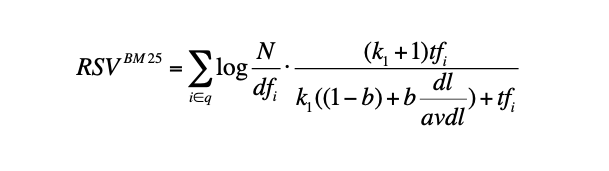

In [16]:
# BM25 model
# k1: governs the importance of within document frequency tf (t, d)
# b: relative importance of within document frequency and document length 
# In most of cases, Typically, k1 is set around [1.2,2] and b around 0.75

k_1 = 2
b = 0.8

dls = scifact_TF_matrix.sum(axis=1).tolist()       # document length calculation, from lab3 
avgdl = np.mean(dls)                   # average document length calculation, from lab3

In [17]:
print("Document length is: " + str(dls[:10]) + " ...")
print("Average doucment length is: " + str(avgdl))

Document length is: [167, 147, 124, 159, 155, 180, 96, 191, 118, 44] ...
Average doucment length is: 128.56395909704804


In [18]:
# BM25 score calculation formula
numerator = np.array((k_1 + 1) * scifact_TF_matrix)
denominator = np.array(k_1 *((1 - b) + b * (dls / avgdl))).reshape(N, 1) + \
                       np.array(scifact_TF_matrix)

BM25_tf = numerator / denominator      # calculate the BM25 term frequency
BM25_idfs = np.array(idfs)             # transform idfs to numpy array, not cover original idfs
BM25_score = BM25_idfs * BM25_tf
BM25_idf_matrix = pd.DataFrame(BM25_score, columns=vocabulary)

In [19]:
BM25_idf_matrix

,aa,aaa,aaaatpas,aaafamili,aab,aabenhus,aacr,aacrthi,aad,aadinduc,...,μm,μmolkg,μmoll,μmwide,μs,σe,σg,χ²,ωloop,ﬁnding
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# The function used to clean the BM25 idf matrix 
def BM25_score_calculator(query_vocabulary_list):                    # calculations inferred from Baeza-Yates and Ribeiro-Neto (2011), and QMUL (2022a).
    document_vocabulary_list = [term for term in query_vocabulary_list if term in BM25_idf_matrix.columns] # remove the query terms that not appear in document, minimize matrix size
    BM25_scores = BM25_idf_matrix[document_vocabulary_list].sum(axis = 1)
    return BM25_scores

In [21]:
BM25_IR_score = BM25_score_calculator(query_vocabulary_list)

In [22]:
IR_score_ranking(10, BM25_IR_score, "BM25") # ranking test

,Rank,Document text,BM25 Document score
Document ID,,,
13069283,1,BACKGROUND Estrogen receptor-positive breast c...,15.648169
24341590,2,CONTEXT The growth inhibitory effect of tamoxi...,15.258304
12438901,3,BACKGROUND For women with oestrogen receptor (...,13.434543
20454006,4,"Diindolylmethane (DIM), a bioactive metabolite...",12.904188
16390264,5,OBJECTIVES To determine the extent to which ty...,8.947178
4886637,6,"Incidences of breast cancer, type 2 diabetes, ...",8.897381
15721252,7,INTRODUCTION Alterations in cell cycle regulat...,8.892143
17163294,8,BACKGROUND Accumulating evidence has shown tha...,8.551385
24873253,9,Patients with metastatic bone disease are at r...,8.244346


## Evaluation 

The qrel(query relevance judgements) tuple list is a kind of ground truth that can help do the query evaluation.



In [23]:
# qrel was extracted at the beginning
np_relve_list = np.array(relve_list).astype(int)

# put document ID list and IR scores in retrieval method part into a new dictionary
VSM_document_ranking = dict(zip([int(doc[0]) for doc in document_id_list], VSM_IR_score))
BM25_document_ranking = dict(zip([int(doc[0]) for doc in document_id_list], BM25_IR_score))
print("VSM document ranking:", VSM_document_ranking)
print("BM25 document ranking:", BM25_document_ranking)

VSM document ranking: {4983: 0.0, 5836: 0.012848660278614431, 7912: 0.0, 18670: 0.0, 19238: 0.0, 33370: 0.006642841833244311, 36474: 0.0, 54440: 0.0, 70115: 0.0, 70490: 0.0, 72159: 0.015603291023394701, 79447: 0.01737421914925495, 87758: 0.0019709843939297667, 92308: 0.0, 92499: 0.0, 97884: 0.01038963073579404, 102662: 0.0, 103007: 0.0, 104130: 0.0, 106301: 0.0, 116792: 0.003432119947960056, 118568: 0.00989558535444698, 120626: 0.009703881482503902, 123859: 0.0, 140874: 0.0, 143251: 0.0, 152245: 0.0, 153744: 0.0, 159469: 0.0, 164189: 0.0, 164985: 0.0, 169264: 0.0, 175735: 0.0, 188911: 0.0, 195352: 0.05668125278491787, 202259: 0.041768053491634725, 207972: 0.0035268894312500787, 213017: 0.005468542623638277, 219475: 0.0, 226488: 0.009649481030022018, 236204: 0.0, 238409: 0.0, 243694: 0.0, 253672: 0.02787180092038749, 263364: 0.03586847911187111, 266641: 0.0, 275294: 0.009204320425873769, 279052: 0.0, 285794: 0.006287632306284243, 293661: 0.024587572232719426, 301838: 0.0, 301866: 0.0299

In [24]:
# precision method
# abandoned because most of relevent value in database are same
# TP(True positive) FP(False positive)
def precision_calculator(query_id, doc_ranking, np_qrels_list, rank_number = 20):  # precision at rank number 
    retrieved_matrix = np.array([d[0] for d in sorted(doc_ranking.items(), 
                                               key = lambda item: item[1], 
                                               reverse = True) if d[1] > 0])  #build evaluation matrix
    TP = 0                   #initialize the TP and FP values     
    FP = 0 
    for doc in retrieved_matrix[:rank_number]:                                 
        if doc in np_qrels_list[np_qrels_list[:, 0] == query_id][:,1]:      
            TP += 1            # if the document match the correct query according to relevance, TP + 1                         
        else:
            FP += 1            # if the document not match the correct query according to relevance, FP + 1  
    precision_rate = TP/(TP+FP) 
    return precision_rate

In [25]:
# precision for single test query
print("For test query id: 30")
print("VSM Precision@20:", precision_calculator(test_id_number, VSM_document_ranking, np_relve_list))
print("BM25 Precision@20:", precision_calculator(test_id_number, BM25_document_ranking, np_relve_list))

For test query id: 30
VSM Precision@20: 0.05
BM25 Precision@20: 0.05


Due to the limitations of the precision method, we **abandoned** the method and adopted a **new** method to evaluate the model.  
**Normalized Discounted Cumulative Gain(NDCG)** is a popular evaluating method.  
Since the groundtruth of many database terms are too close, we use the NDCG instead precision method.

In [26]:
# NDCG method
def NDCG_calculator(query_id, doc_ranking, np_qrels_list, rank_number = 20):  # for single query in top n documents                                          
    y_score = np.array([doc for doc in sorted(doc_ranking.items(),      # get doc_id and score
                                          key = lambda item: item[1], 
                                          reverse = True) if doc[1] > 0]) 
    y_true = np.array([])
    for doc in y_score:
        if doc[0] in np_qrels_list[np_qrels_list[:, 0] == query_id][:,1]:     
            y_true = np.append(y_true, doc[1])                    
        else:                                                   
            y_true = np.append(y_true, 0)
    return ndcg_score(np.expand_dims(y_true,axis = 0), 
                      np.expand_dims(y_score[:,1],axis = 0), k = rank_number)

In [27]:
# NDCG for single test query
print("For test query id: 30")
print("VSM NDCG@20:", NDCG_calculator(test_id_number, VSM_document_ranking, np_relve_list))
print("BM25 NDCG@20:", NDCG_calculator(test_id_number, BM25_document_ranking, np_relve_list))

For test query id: 30
VSM NDCG@20: 0.43067655807339295
BM25 NDCG@20: 0.6309297535714573


In [28]:
def get_NDCG(query_id, IR_method, rank_number):                         # The interface to combine VSM and BM25 NDCG calculation
  result_query = [query_pair for query_pair in queries if query_pair[0] == query_id][0][1]    # match the confirmed query pair
  TF_vector_array, query_vocabulary_list = TF_query_vectorizer(result_query)              # TF vectorizing the query pair
  if IR_method == "VSM":  eval_scores = VSM_score_calculator(TF_vector_array)              #  VSM model
  if IR_method == "BM25":  eval_scores = BM25_score_calculator(query_vocabulary_list)          #  BM25 model
  doc_ranking = dict(zip([int(doc[0]) for doc in document_id_list], eval_scores))
  ndcg = NDCG_calculator(query_id, doc_ranking, np_relve_list, rank_number)               #  produce the NDCG for related method
  return ndcg

In [29]:
def range_evaluate(evaluate_range, model, rank_number):                              # batch test function
  result = 0                                                    # initialize the result value
  for i in query_id_list[:evaluate_range]:
    result += (get_NDCG(i, model, rank_number)/evaluate_range)                        # calculate the mean averge NDCG for top n documents  
  print("The mean NDCG@20 of", model, "for the top", evaluate_range, "querys:", result)         # output the result
  return 

In [30]:
# NDCG for batch test
test_range = 100
range_evaluate(test_range, "VSM", 20)
range_evaluate(test_range, "BM25", 20)

The mean NDCG@20 of VSM for the top 100 querys: 0.5725740489076144
The mean NDCG@20 of BM25 for the top 100 querys: 0.641299556879585


**Conclusion:** BM25 has better performance in precise, but it takes more RAM resources than VSM

# SciFact database Information Retrieval Search Engine

In [31]:
# search engine function
def IR_search_engine(input_query_content, IR_method = "VSM", rank_number = 20):           # VSM is the default method
    if(input_query_content == ""):                     #if user not input the query, remind him
      return "Please input your query!"
      
    pre_processed_query = pre_processing([input_query_content])[0]      # extract the matched query array  
    query_TF_vector_array, query_vocabulary_list = TF_query_vectorizer(pre_processed_query)
    if IR_method == "VSM":  scores = VSM_score_calculator(query_TF_vector_array)      # VSM modle
    if IR_method == "BM25":  scores = BM25_score_calculator(query_vocabulary_list)     # BM25 modle
    return IR_score_ranking(rank_number, scores, IR_method)

In [32]:
#@title _Welcome to use the SciFact database search engine!_ {run: "auto"}
#@markdown #### Enter what you want to research here:
Query = "Obesity is a multifactorial disease with a marked genetic component."  #@param {type: "string"}
#@markdown #### Choose the IR model you want to use:
Model = 'BM25' #@param ["VSM", "BM25"]           
#@markdown #### Here is the potential answers:
IR_search_engine(Query, Model)      #run search engine function

,Rank,Document text,BM25 Document score
Document ID,,,
21641088,1,Obesity is a multifactorial disease with a mar...,10.414708
4427060,2,"Crohn's disease and ulcerative colitis, the tw...",6.418154
4353857,3,The extreme obesity of the obese (ob/ob) mouse...,6.312347
22478394,4,INTRODUCTION Triglyceride accumulation in the ...,6.284190
23389795,5,"Here, we give a historical overview of the sea...",6.051254
4345757,6,Obesity is now so common within the world's po...,5.903979
3315558,7,An analysis of the genetic factors in obesity ...,5.372821
10889845,8,"Obesity and insulin resistance, the key featur...",5.270124
29638116,9,Defined genetic models based on human pluripot...,4.979002
